In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as SklearnPCA
import matplotlib.pyplot as plt

# Load the dataset
data = load_breast_cancer()
X = data.data  # Features (30 columns)
y = data.target  # Labels (0=malignant, 1=benign)

# Normalize the data

# Calculate mean and standard deviation for each feature
X_mean = np.mean(X, axis=0)  # Mean of each column
X_std = np.std(X, axis=0)    # Std dev of each column

# Standardize: subtract mean and divide by std
X_normalized = (X - X_mean) / X_std



In [ ]:
# positives values only
def relu(z):
    return np.maximum(0, z)

# 1 for +ve values 0 for else
#.astype(float) -> must be 0 or 1 not boolean
def relu_deriv(z):
    return (z>0).astype(float)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

#σ′(z)=σ(z)(1−σ(z))
def sigmoid_deriv(z):
    s =sigmoid(z)
    return s*(1-s)

def tanh(z):
    return np.tanh(z)

#d/d ​tanh(z)=1−tanh^2(z)
def tanh_deriv(z):
    return 1 - np.tanh(z)**2


def linear(x):
    return x


def linear_deriv(x):
    return 1

In [ ]:
import numpy as np
class Autoencoder:
  #layer_dimensions->list with dimensions ofa eacher layer from enoder to bottleneck to decoder
  #activations->a dictionary mapping each layer to its activation function
  #lr learning rate ->s step size during gradient descent
  # lambda l2 regularization
  #L->
    def __init__(self,layer_dimensions,lr=0.01,l2=1e-4):
        self.lr=lr
        self.l2=l2
        #w-> weight matrix , b bias
        self.L=len(layer_dimensions)-1
        self.W,self.b ={}, {}
        self.activations = {
    1: relu,
    2: relu,
    3: sigmoid,
    4: linear
}

        self.activation_derivs = {
    1: relu_deriv,
    2: relu_deriv,
    3: sigmoid_deriv,
    4: linear_deriv
}

        # iterates through layers
        #np.random.randn->samples from standard normal distribution mean=0 std=1
        for i in range(1, self.L+ 1):
          #if I initialised with all zeros neurons learn the same things
          #if all weights start the same:all neurons receive identical gradients and remain identical
          # *0.01-> scaling cause when weights are large z=wx z is larger
          #w n(i)*n(i-1)  A  m*n(i-1)   z m*n(i)
            #self.W[i]=np.random.randn(layer_dimensions[i-1],layer_dimensions[i])*0.01
            fan_in = layer_dimensions[i-1]
            fan_out = layer_dimensions[i]

    # He initialization (good for ReLU)
            limit = np.sqrt(2.0 / fan_in)
            self.W[i] = np.random.randn(fan_in, fan_out) * limit
            self.b[i] = np.zeros((1, fan_out))
          #b[i].shape =(1-> no of rows,no of neuros in the layer)


    def train(self, X, epochs=100, batch_size=32, decay=0.99):
        losses = []
        #epoch->one full pass over the entire dataset
        #np.random.permutation(len(X))creates a random permutation of indices from 0 to len(X)
        #reorders the dataset X according to this permutation.
        for e in range(epochs):
            perm = np.random.permutation(len(X))
            X_shuffled=X[perm]
        #iterates over the dataset in chunks of size batch_size
            for i in range(0, len(X), batch_size):
              #extracts the mini-batch
                batch = X_shuffled[i:i+batch_size]
                out = self.forward(batch)
                self.backward(batch)
                #decays the learning rate so the training converge smoothly
            self.lr *= decay
            #MSE loss 1/n (x telda -x)^2
            loss = np.mean((self.forward(X) - X) ** 2)
            losses.append(loss)
        return losses

    def forward(self, X):
      #Initialize storage for intermediate values
      #A stores activations of all layers
      #Treats the input as the activation of layer 0
        self.A,self.Z ={0: X},{}
        # A[i-1]features learnt so far
        #w[i]learns how to combine features
        # bias shifts the activation threshold
        # @ matrix multiplication
        for i in range(1, self.L+1):
          #z -> the output of the layer
          #apply an activation to z to add non-linearity

            self.Z[i]=self.A[i-1]@self.W[i]+self.b[i]
            self.A[i] = self.activations[i](self.Z[i])
        return self.A[self.L]


#Backpropagation tells each weight how to change to make the output closer to the input.
#Computes how much each weight contributed to the error
#Uses the chain rule to propagate error from output to input
#Updates parameters to reduce reconstruction loss
    def backward(self, X):
        m = X.shape[0]
        # dz/dl = x telda -x
        dZ = self.A[self.L]-X
        for i in reversed(range(1, self.L + 1)):
          #.T->transpose
          #regularization cause it's easy to get output which is the input so it could memorize the data so it helps to generalize effectively
            dW = (self.A[i-1].T @ dZ) / m + self.l2 * self.W[i]
            #loops over all samples so we take the average
            db = np.mean(dZ,axis=0,keepdims=True)
            if i > 1:
                dZ = (dZ @ self.W[i].T) * self.activation_derivs[i-1](self.Z[i-1])
                #update the weight and bias
                #w=w-lr*dw
                #b=b-lr*db
            self.W[i] -= self.lr * dW
            self.b[i] -= self.lr * db

    def encode(self, X):

        self.A = {0: X}  # reset storage after forward
        self.Z = {}
        # goes to the encoder and bottleneck only
        bottleneck_index = self.L // 2
        for i in range(1, bottleneck_index + 1):
            self.Z[i] = self.A[i-1] @ self.W[i] + self.b[i]
            self.A[i] = self.activations[i](self.Z[i])

        return self.A[bottleneck_index]


In [ ]:
#normalized_mutual_info implementation from scratch
#NMI measures how much information the predicted clusters share with the true labels.
from math import log

def normalized_mutual_info(labels_true, labels_pred):
    #convert them to numpy arrays
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    #no of samples
    n = len(labels_true)
    #the true labels and clusters
    unique_true = np.unique(labels_true)
    unique_pred = np.unique(labels_pred)

    # Compute probabilities of true classses and the clusters
    #number of samples in class i/n
    #number of samples in cluster j/n
    p_true = np.array([np.sum(labels_true==c)/n for c in unique_true])
    p_pred = np.array([np.sum(labels_pred==c)/n for c in unique_pred])

    # Joint probability-> This tells you how many points belong to class i and cluster j
    p_joint = np.zeros((len(unique_true), len(unique_pred)))
    for i, c_true in enumerate(unique_true):
        #compares each true label with true labels
        #compares each predicted label with the rest
        # then compare them with each other and sum them and divide by n to calculate the probability
        for j, c_pred in enumerate(unique_pred):
            p_joint[i,j] = np.sum((labels_true==c_true) & (labels_pred==c_pred)) / n

    # Mutual information-> if knowing cluster helps with knowing labels
    #p(y,c)/p(y)p(c)
    #if independent p(y,c)=p(y)p(c)->0 no informain gain

    MI = 0
    for i in range(len(unique_true)):
        for j in range(len(unique_pred)):
            if p_joint[i,j] > 0:
                MI += p_joint[i,j] * log(p_joint[i,j]/(p_true[i]*p_pred[j]))

    # Entropies
    H_true = -np.sum(p_true * np.log(p_true + 1e-10))
    H_pred = -np.sum(p_pred * np.log(p_pred + 1e-10))

    NMI = MI / ((H_true + H_pred)/2)
    return NMI

In [ ]:
#adjusted_rand_index implementation from scratch
import numpy as np
from math import comb

def adjusted_rand_index(labels_true, labels_pred):
   #convert them to numpy arrays
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)

    n = len(labels_true)
    #max label +1 [0 1]-> 2 rows needed same for columns and fill them with zeros
    contingency = np.zeros((labels_true.max()+1, labels_pred.max()+1), dtype=int)

    for i in range(n):
      # for wvery sample fills the table
        contingency[labels_true[i], labels_pred[i]] += 1

    #for every row all pairs of points that are in the same true cluster.
    sum_comb_c= sum(comb(n_c, 2) for n_c in contingency.sum(axis=1))
    #for every column all pairs in the same predicted cluster.
    sum_comb_k= sum(comb(n_k, 2) for n_k in contingency.sum(axis=0))
    #This is the number of pairs that are in the same cluster in both true and predicted labels.
    sum_comb= sum(comb(n_ij, 2) for n_ij in contingency.flatten())
    comb_n = comb(n, 2)

    #Expected index: expected number of agreements by chance.
    #Maximum index: maximum possible number of agreements.
    expected_index = sum_comb_c * sum_comb_k / comb_n
    max_index = 0.5 * (sum_comb_c + sum_comb_k)
    #Observed−Expected/Maximum−Expected​
    ari = (sum_comb - expected_index) / (max_index - expected_index)
    return ari

In [ ]:
def compute_inertia(X, centroids, labels):
    inertia = 0
    #loops over each cluster
    for i in range(len(centroids)):
      #the points in each cluster
        cluster_points = X[labels == i]
        #the sum ofthe dist btw points and centroid squared
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[i]) ** 2)
    return inertia

In [ ]:
def silhouette_score(X, labels):
    n = len(X)
    unique_labels = np.unique(labels)

    if len(unique_labels) == 1:
        return 0  # Only one cluster

    scores = []
    for i in range(n):
        same_cluster = X[labels == labels[i]]

        # Skip if cluster has only one point
        if len(same_cluster) == 1:
            continue

        # Calculate a(i) - exclude the point itself
        a = np.mean([euclidean_distance(X[i], x) for x in same_cluster if not np.array_equal(x, X[i])])

        # Calculate b(i)
        b_values = []
        for label in unique_labels:
            if label != labels[i]:
                other_cluster = X[labels == label]
                if len(other_cluster) > 0:
                    b_values.append(np.mean([euclidean_distance(X[i], x) for x in other_cluster]))

        if not b_values:
            continue

        b = min(b_values)

        if max(a, b) > 0:
            scores.append((b - a) / max(a, b))

    return np.mean(scores) if scores else 0


In [ ]:

import numpy as np

# -------- Distance --------
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# -------- Initialization Methods --------
def init_random(X, k, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    idx = np.random.choice(len(X), k, replace=False)
    return X[idx]

def init_kmeans_plus_plus(X, k, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    n_samples = X.shape[0]
    centroids = [X[np.random.randint(n_samples)]]

    for _ in range(1, k):
        distances = np.array([
            min(np.linalg.norm(x - c) ** 2 for c in centroids)
            for x in X
        ])
        probabilities = distances / (np.sum(distances) + 1e-10)  # Add small epsilon
        probabilities = np.maximum(probabilities, 0)  # Ensure non-negative
        probabilities /= probabilities.sum()  # Normalize

        next_centroid = X[np.random.choice(n_samples, p=probabilities)]
        centroids.append(next_centroid)

    return np.array(centroids)

# -------- Cluster Assignment --------
def assign_clusters(X, centroids):
    labels = []
    for x in X:
        distances = [euclidean_distance(x, c) for c in centroids]
        labels.append(np.argmin(distances))
    return np.array(labels)

# -------- Update Centroids --------
def update_centroids(X, labels, k, old_centroids):
    new_centroids = []
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            new_centroids.append(cluster_points.mean(axis=0))
        else:
            # Keep old centroid if cluster is empty
            new_centroids.append(old_centroids[i])
    return np.array(new_centroids)

# -------- Full K-Means --------
def kmeans( X,k, init_method="random",   # "random" or "kmeans++"
max_iters=100, tol=1e-4, random_state=None):


    # Initialization
    if init_method == "kmeans++":
        centroids = init_kmeans_plus_plus(X, k, random_state)
    else:
        centroids = init_random(X, k, random_state)

    inertia_history = []
    n_iter = 0

    for iteration in range(max_iters):
        # Assign clusters
        labels = assign_clusters(X, centroids)

        # Compute inertia
        inertia = compute_inertia(X, centroids, labels)
        inertia_history.append(inertia)

        # Update centroids
        new_centroids = update_centroids(X, labels, k, centroids)

        # Update iteration count
        n_iter = iteration + 1

        # Convergence check
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    # Final inertia
    final_inertia = inertia_history[-1] if inertia_history else 0

    return centroids, labels, final_inertia, n_iter, inertia_history

In [ ]:
def davies_bouldin_index(X, labels):
    # Identify clusters
    unique_labels = np.unique(labels)
    k = len(unique_labels)

    # Compute centroids
    centroids = []
    for l in unique_labels:
        centroids.append(np.mean(X[labels == l], axis=0))
    centroids = np.array(centroids)

    # Compute cluster scatter (average distance of points to their centroid)
    scatters = []
    for i, l in enumerate(unique_labels):
        cluster_points = X[labels == l]
        scatter = np.mean(np.linalg.norm(cluster_points - centroids[i], axis=1))
        scatters.append(scatter)
    scatters = np.array(scatters)

    # Compute Davies–Bouldin index
    db_values = []

    for i in range(k):
        max_ratio = -np.inf #find the maximum ratio for cluster i
        for j in range(k):
            if i != j:
                dist_centroids = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (scatters[i] + scatters[j]) / dist_centroids
                max_ratio = max(max_ratio, ratio)
        db_values.append(max_ratio)

    return np.mean(db_values)


In [ ]:
# Calculates Calinski-Harabasz Index (Variance Ratio Criterion)
def calculate_calinski_harabasz(X, labels):
    n_samples = X.shape[0] #Gets the total number of data points in the dataset
    classes = np.unique(labels) #Finds all the unique cluster IDs present in the labels array
    n_classes = len(classes) #Counts how many unique clusters exist

    #safty check to check if there are atleast 2 clusters to be calculated
    if n_classes < 2: return 0.0

    mean_global = np.mean(X, axis=0) # Calculates the global centroid (mean) of the entire dataset. This represents the center point of all data combined
    WG = 0.0 # Within group
    BG = 0.0 # Between group

    #Starts a loop to iterate through each unique cluster ID
    for c in classes:
        points = X[labels == c] #Filters the dataset X to get only the data points that belong to the current cluster c
        mean_k = np.mean(points, axis=0) #Calculates the centroid (mean) of the current cluster c

        #Calculates the squared distance between each point in the cluster and that cluster's centroid (mean_k)
        #Sums these squared distances and adds them to the running total WG
        WG += np.sum((points - mean_k) ** 2)
        #Calculates the squared distance between the current cluster's centroid (mean_k) and the global dataset centroid (mean_global)
        #Weights this distance by the number of points in the cluster
        #Adds it to the running total
        BG += points.shape[0] * np.sum((mean_k - mean_global) ** 2)

    #Computes the final ratio
    score = (BG / (n_classes - 1)) / (WG / (n_samples - n_classes))
    return score

In [ ]:
# Calculates Clustering Purity
def calculate_purity(y_true, y_pred):
    clusters = np.unique(y_pred) #finds all unique cluster ids
    count_sum = 0
    for cluster in clusters:
        #resulted cluster_labels contains only the actual ground truth labels for data inside a specific cluster
        cluster_labels = y_true[y_pred == cluster]
        #checks if a cluster is not empty before starting
        if len(cluster_labels) > 0:
            counts = np.bincount(cluster_labels) #counts how many times each true label appears in this specific cluster
            count_sum += np.max(counts) #identifies the majority class in this cluster and adds that count to the total.
    return count_sum / len(y_true) # division to make sure that ratio is between 0-1


Training Autoencoder with bottleneck=2


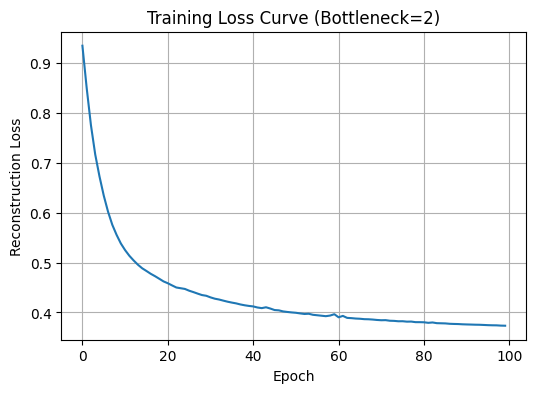


Training Autoencoder with bottleneck=5


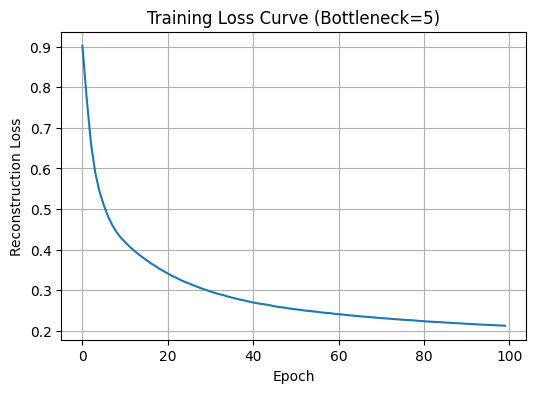


Training Autoencoder with bottleneck=10


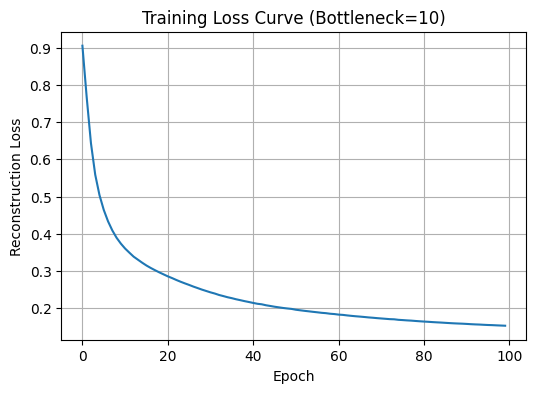


Training Autoencoder with bottleneck=15


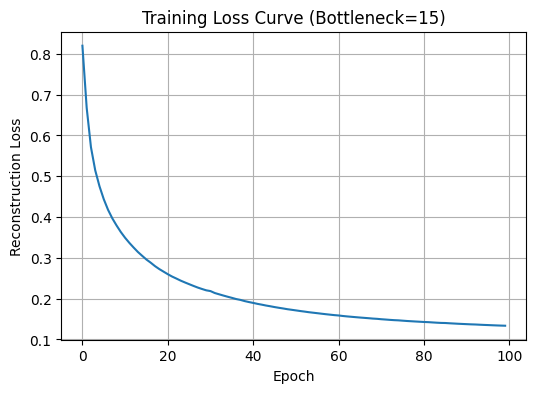


Training Autoencoder with bottleneck=20


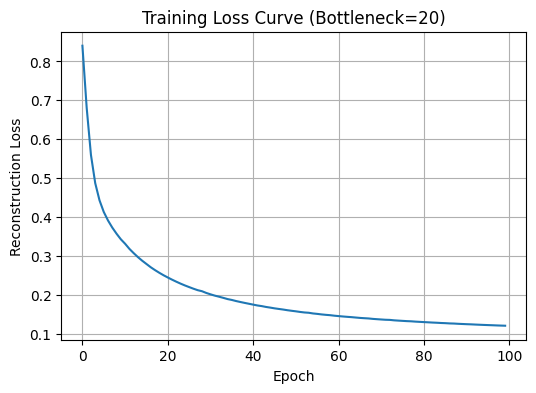


Reconstruction Loss per Bottleneck Size:
Bottleneck=2: 0.3733
Bottleneck=5: 0.2125
Bottleneck=10: 0.1530
Bottleneck=15: 0.1337
Bottleneck=20: 0.1203

K-Means Clustering Results:
Bottleneck=2 | ARI=0.030, NMI=0.056, Silhouette=0.819, WCSS=128.59,DBI=0.35,CH=1941.87,Purity=0.65
Bottleneck=5 | ARI=0.486, NMI=0.461, Silhouette=0.712, WCSS=856.05,DBI=0.49,CH=1317.37,Purity=0.85
Bottleneck=10 | ARI=0.471, NMI=0.462, Silhouette=0.683, WCSS=1612.04,DBI=0.58,CH=1034.07,Purity=0.85
Bottleneck=15 | ARI=0.476, NMI=0.466, Silhouette=0.676, WCSS=2298.27,DBI=0.60,CH=977.14,Purity=0.85
Bottleneck=20 | ARI=0.471, NMI=0.449, Silhouette=0.666, WCSS=3321.14,DBI=0.61,CH=890.13,Purity=0.85


In [ ]:
#experiment 5
import matplotlib.pyplot as plt

bottleneck_sizes = [2, 5, 10, 15, 20]
epochs = 100
batch_size = 32

#final loss for each bottleneck size
reconstruction_losses = {}
latent_features = {}
kmeans_results = {}
true_labels = y

for size in bottleneck_sizes:
    print(f"\nTraining Autoencoder with bottleneck={size}")


    ae = Autoencoder(layer_dimensions=[X.shape[1], 50, size, 50, X.shape[1]],lr=0.01)
    #a list of reconstruction loss values, one per epoch
    losses = ae.train(X_normalized, epochs=epochs, batch_size=batch_size)
    #-1 -> last element
    #a dictionary keyed by bottleneck size that stores the final reconstruction loss for this bottleneck size
    reconstruction_losses[size] = losses[-1]

    plt.figure(figsize=(6,4))
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Loss")
    plt.title(f"Training Loss Curve (Bottleneck={size})")
    plt.grid(True)
    plt.show()

    features = ae.encode(X)
    #Each data point in your dataset gets converted into a smaller set of values.
    #These values represent the essential information of the original input, compressed into fewer dimensions
    latent_features[size] = features

    # Standardize latent features
    features_mean = np.mean(features, axis=0, keepdims=True)
    features_std = np.std(features, axis=0, keepdims=True)
    features_std = np.where(features_std < 1e-10, 1.0, features_std)  # Avoid division by zero
    features_scaled = (features - features_mean) / features_std

    # Store scaled features
    latent_features[size] = features_scaled


    centroids, labels, inertia, n_iter, history = kmeans(features_scaled,k=2,init_method="kmeans++",random_state=42)


    ari = adjusted_rand_index(true_labels, labels)
    nmi = normalized_mutual_info(true_labels, labels)
    silhouette = silhouette_score(features_scaled, labels)
    db_index = davies_bouldin_index(features_scaled, labels)
    calinski_harabasz = calculate_calinski_harabasz(features_scaled, labels)
    purity = calculate_purity(true_labels, labels)


    kmeans_results[size] = {
    'ARI': ari,
    'NMI': nmi,
    'Silhouette': silhouette,
    'WCSS': inertia,
    'Iterations': n_iter,
    'davies_bouldin_index': db_index,
    'calinski_harabasz': calinski_harabasz,
    'purity': purity,
    'labels': labels  }


print("\nReconstruction Loss per Bottleneck Size:")
for size, loss in reconstruction_losses.items():
    print(f"Bottleneck={size}: {loss:.4f}")

print("\nK-Means Clustering Results:")
for size, metrics in kmeans_results.items():
    print(
        f"Bottleneck={size} | "
        f"ARI={metrics['ARI']:.3f}, "
        f"NMI={metrics['NMI']:.3f}, "
        f"Silhouette={metrics['Silhouette']:.3f}, "
        f"WCSS={metrics['WCSS']:.2f}"
        f",DBI={metrics['davies_bouldin_index']:.2f}"
        f",CH={metrics['calinski_harabasz']:.2f}"
        f",Purity={metrics['purity']:.2f}"
    )



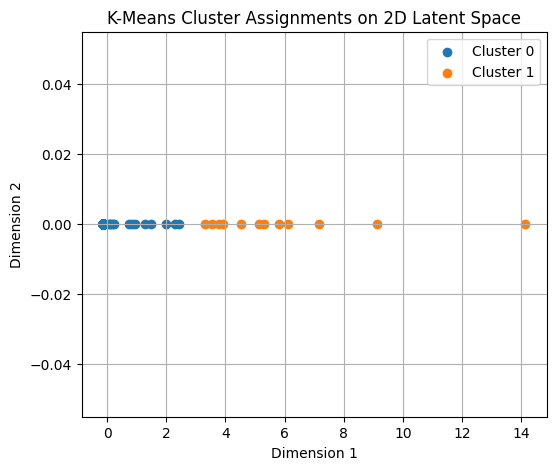

In [ ]:
#K-Means Cluster Assignments on 2D Latent Space

latent_2d = latent_features[2]  # Using the 2D bottleneck features
labels = kmeans_results[2]['labels']
plt.figure(figsize=(6,5))
for cluster_id in np.unique(labels):
    plt.scatter(latent_2d[labels==cluster_id, 0],
                latent_2d[labels==cluster_id, 1],
                label=f"Cluster {cluster_id}")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("K-Means Cluster Assignments on 2D Latent Space")
plt.legend()
plt.grid(True)
plt.show()

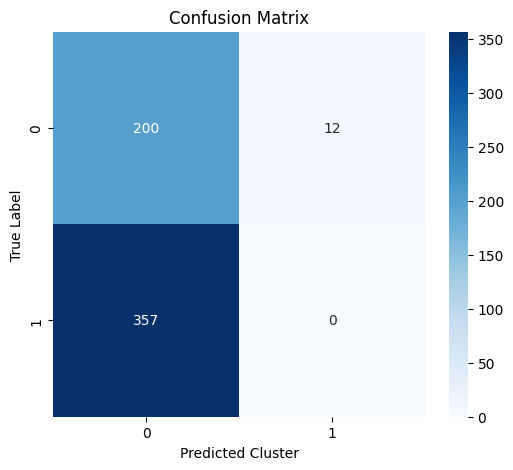

In [ ]:

#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
